In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

# Load data
data = pd.read_csv('train_subset.csv')
data['click_time'] = pd.to_datetime(data['click_time'])
data.head(5)

In [ ]:
print(f'Number of rows and columns: {data.shape}\n')
print(f'Missing value count by column:\n{data.isna().sum()}\n')
print(f'Class frequency:\n{data.is_attributed.value_counts()}\n')
print(f'Date interval of the dataset: {data.click_time.min()}-{data.click_time.max()}')

Number of rows and columns: (4000000, 7)

Missing value count by column:
ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

Class frequency:
0    3993058
1       6942
Name: is_attributed, dtype: int64

Date interval of the dataset: 2017-11-06 14:32:21-2017-11-06 18:31:23


In [ ]:
# Categorical features
categorical = ['ip','app', 'device','os', 'channel'] 
for label in [0,1]:
  print(f'\n************** Class {label} **************n')
  for col in categorical:
    print('\n','--'*5, col,'--'*5)
    print(f'# Unique values: {data[data.is_attributed==label][col].nunique()}')
    print(f'# Values with less than 3 occurence: {sum(data[data.is_attributed==label][col].value_counts()<3)}')


************** Class 0 **************n

 ---------- ip ----------
# Unique values: 53902
# Values with less than 3 occurence: 6251

 ---------- app ----------
# Unique values: 285
# Values with less than 3 occurence: 62

 ---------- device ----------
# Unique values: 526
# Values with less than 3 occurence: 313

 ---------- os ----------
# Unique values: 229
# Values with less than 3 occurence: 63

 ---------- channel ----------
# Unique values: 159
# Values with less than 3 occurence: 7

************** Class 1 **************n

 ---------- ip ----------
# Unique values: 6320
# Values with less than 3 occurence: 6232

 ---------- app ----------
# Unique values: 117
# Values with less than 3 occurence: 36

 ---------- device ----------
# Unique values: 258
# Values with less than 3 occurence: 195

 ---------- os ----------
# Unique values: 56
# Values with less than 3 occurence: 6

 ---------- channel ----------
# Unique values: 121
# Values with less than 3 occurence: 20


(0.0, 50.0)

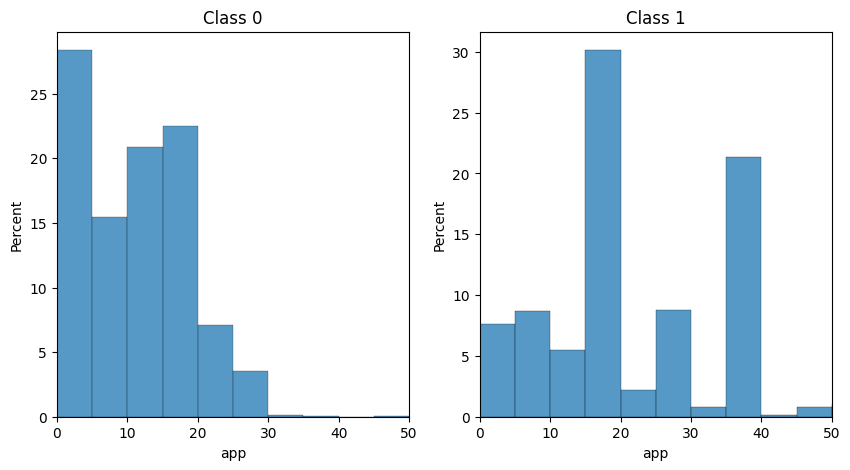

In [ ]:
# Distribution of Apps by class
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(data[data.is_attributed==0].app, binwidth=5, stat = 'percent')
plt.xlim((0,50))
plt.title('Class 0')
plt.subplot(1,2,2)
sns.histplot(data[data.is_attributed==1].app, binwidth=5, stat = 'percent')
plt.title('Class 1')
plt.xlim((0,50))

Text(0.5, 1.0, 'Class 1')

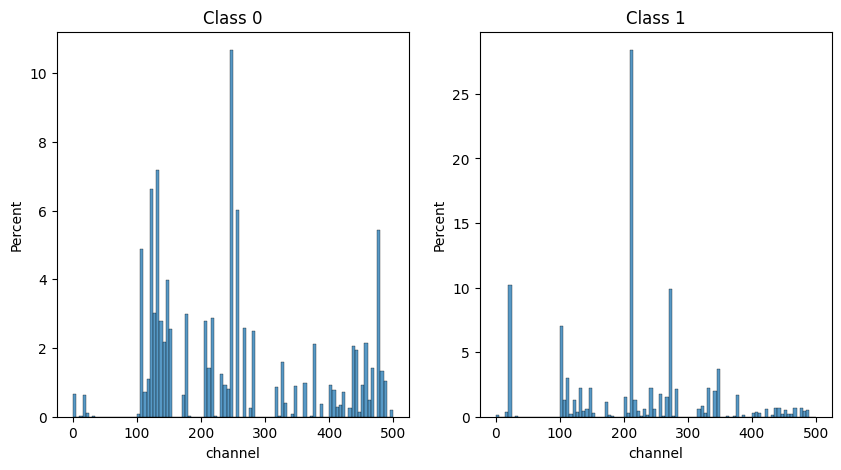

In [ ]:
# Distribution of Channles by class
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(data[data.is_attributed==0].channel, binwidth=5, stat = 'percent')
plt.title('Class 0')
plt.subplot(1,2,2)
sns.histplot(data[data.is_attributed==1].channel, binwidth=5, stat = 'percent')
plt.title('Class 1')


(0.0, 100.0)

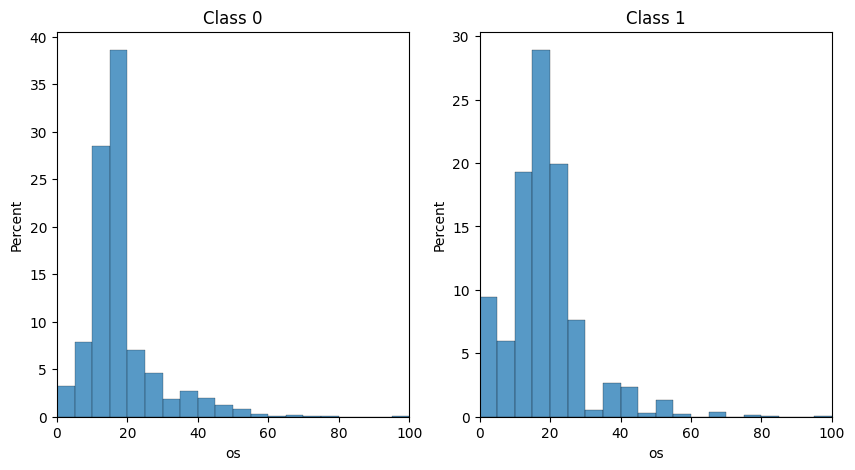

In [ ]:
# Distribution of os by class
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(data[data.is_attributed==0].os, binwidth=5, stat = 'percent')
plt.xlim((0,100))
plt.title('Class 0')
plt.subplot(1,2,2)
sns.histplot(data[data.is_attributed==1].os,  binwidth=5, stat = 'percent')
plt.title('Class 1')
plt.xlim((0,100))

In [ ]:
 # Calculate IP click count
ip_click_count = data.groupby('ip')['click_time'].count().reset_index()
ip_click_count.columns = ['ip', 'IP_click_count']

# Calculate IP first click
data['IP_first_click'] = data.groupby('ip')['click_time'].transform(lambda x: x == x.min()).astype(int)

# Calculate IP time since last click
data['IP_time_since_last_click'] = data.sort_values('click_time').groupby('ip')['click_time'].diff().dt.total_seconds()
data['IP_time_since_last_click'] = data['IP_time_since_last_click'].fillna(data['IP_time_since_last_click'].mean())

# Calculate IP download count
ip_download_ratio = data.groupby('ip')['is_attributed'].mean().reset_index()
ip_download_ratio.columns = ['ip', 'IP_download_ratio']

In [ ]:
# Combine the data
combined = data.merge(ip_click_count, on = 'ip').merge(ip_download_ratio, on = 'ip')
combined.head()

,ip,app,device,os,channel,click_time,is_attributed,IP_first_click,IP_time_since_last_click,IP_click_count,IP_download_ratio
0,83230,3,1,13,379,2017-11-06 14:32:21,0,1,70.35272,522,0.001916
1,83230,2,1,3,477,2017-11-06 16:00:31,0,0,5290.00000,522,0.001916
2,83230,12,1,13,178,2017-11-06 16:00:48,0,0,17.00000,522,0.001916
3,83230,9,1,13,134,2017-11-06 16:00:50,0,0,2.00000,522,0.001916
4,83230,2,1,19,237,2017-11-06 16:00:56,0,0,6.00000,522,0.001916


In [ ]:
# Compare classes in terms of new features
new_cols = ['IP_click_count', 'IP_first_click', 'IP_time_since_last_click', 'IP_download_ratio']
for col in new_cols:
  print('\n',col)
  print(combined.groupby('is_attributed')[col].agg(['min', 'mean', 'max', 'std']))


 IP_click_count
               min         mean    max          std
is_attributed                                      
0                1  1151.064314  24746  3254.679437
1                1   466.658744  24746  2248.259606

 IP_first_click
               min      mean  max       std
is_attributed                              
0                0  0.018998    1  0.136518
1                0  0.271968    1  0.445005

 IP_time_since_last_click
               min        mean     max         std
is_attributed                                     
0              0.0   69.986897  9350.0  317.064053
1              0.0  280.775553  8591.0  787.790577

 IP_download_ratio
                    min      mean       max       std
is_attributed                                        
0              0.000000  0.001240  0.666667  0.010009
1              0.000086  0.287003  1.000000  0.382295


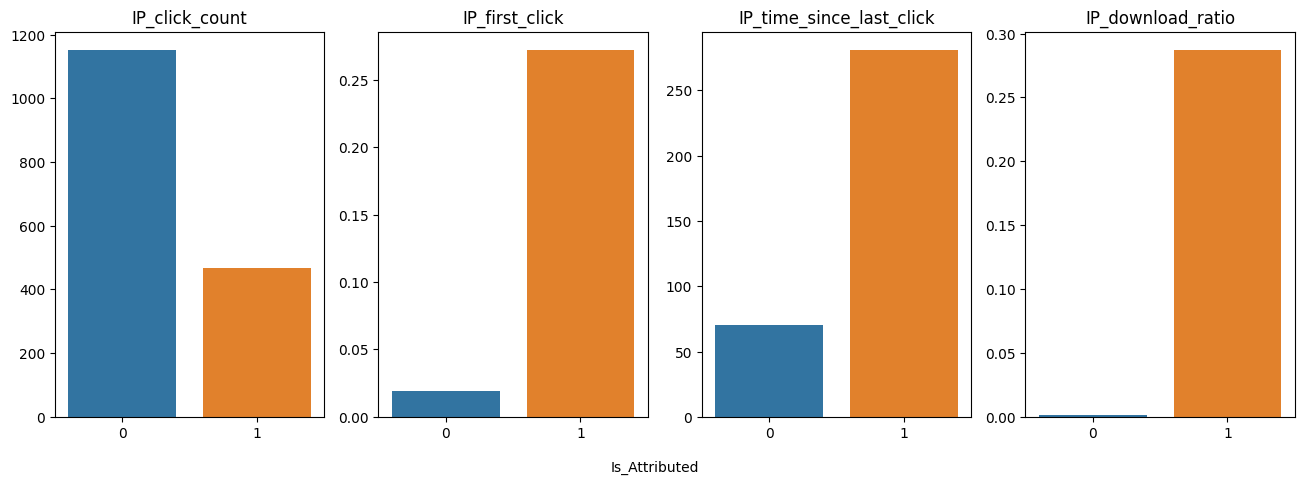

In [ ]:
# Compare classes in terms of new features
new_cols = ['IP_click_count', 'IP_first_click', 'IP_time_since_last_click', 'IP_download_ratio']
fig = plt.figure(figsize = (16,5))
for i,col in enumerate(new_cols):
  plt.subplot(1,4,i+1)
  grouped_df = combined.groupby('is_attributed')[col].mean().reset_index()
  sns.barplot(x='is_attributed', y=col, data=grouped_df)
  plt.title(col)
  plt.xlabel('')
  plt.ylabel('')
fig.text(0.5, 0.0, 'Is_Attributed', ha='center')
plt.show()